In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from itertools import combinations

from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer






import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None
plt.rcParams["axes.grid"] = 0


# RFM Analysis

<a id="section-four"></a>


Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:

**Recency**: How recently a customer has made a purchase

**Frequency**: How often a customer makes a purchase

**Monetary** Value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.



Let's perform RFM Analysis on our data.



# 1) Preparing RFM Table

In [2]:
df = pd.read_csv("online_retail_final.csv")
display(df.head())

print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


(392735, 9)


In [3]:
df.dtypes

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
TotalPrice     float64
dtype: object

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [5]:
print("Min date: {} \nMax date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00


In [6]:
last_day = df.InvoiceDate.max() + dt.timedelta(days = 1)

In [7]:
rfm_table = df.groupby("CustomerID").agg({"InvoiceDate": lambda x: (last_day - x.max()).days,
                                         "InvoiceNo": "nunique",
                                         "TotalPrice": "sum"})

rfm_table.rename(columns = {"InvoiceDate": "Recency",
                            "InvoiceNo": "Frequency",
                            "TotalPrice": "Monetary"}, inplace = True)

rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,7,4060.40
12348.0,75,4,1437.24
12349.0,19,1,1417.60
12350.0,310,1,294.40
12352.0,36,7,1385.74


In [8]:
r_labels = range(5, 0, -1)
fm_labels = range(1, 6)

rfm_table["R"] = pd.qcut(rfm_table["Recency"], 5, labels = r_labels)
rfm_table["F"] = pd.qcut(rfm_table["Frequency"].rank(method = 'first'), 5, labels = fm_labels)
rfm_table["M"] = pd.qcut(rfm_table["Monetary"], 5, labels = fm_labels)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12347.0,2,7,4060.40,5,5,5
12348.0,75,4,1437.24,2,4,4
12349.0,19,1,1417.60,4,1,4
12350.0,310,1,294.40,1,1,2
12352.0,36,7,1385.74,3,5,4


In [9]:
rfm_table["RFM_Segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)
rfm_table["RFM_Score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,2,7,4060.40,5,5,5,555,15
12348.0,75,4,1437.24,2,4,4,244,10
12349.0,19,1,1417.60,4,1,4,414,9
12350.0,310,1,294.40,1,1,2,112,4
12352.0,36,7,1385.74,3,5,4,354,12





# 2) RFM Segments

**Champions**: Bought recently, buy often and spend the most

**Loyal customers**: Buy on a regular basis. Responsive to promotions.

**Potential loyalist**: Recent customers with average frequency.

**Recent customers**: Bought most recently, but not often.

**Promising**: Recent shoppers, but haven’t spent much.

**Needs attention**: Above average recency, frequency and monetary values. May not have bought very recently though.

**About to sleep**: Below average recency and frequency. Will lose them if not reactivated.

**At risk**: Some time since they’ve purchased. Need to bring them back!

**Can’t lose them**: Used to purchase frequently but haven’t returned for a long time.

**Hibernating**: Last purchase was long back and low number of orders. May be lost.



In [10]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfm_table2=rfm_table
rfm_table['Segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12347.0,2,7,4060.40,5,5,5,555,15,Champions
12348.0,75,4,1437.24,2,4,4,244,10,At-Risk
12349.0,19,1,1417.60,4,1,4,414,9,Promising
12350.0,310,1,294.40,1,1,2,112,4,Hibernating
12352.0,36,7,1385.74,3,5,4,354,12,Loyal Customers




# 3) Visualizing RFM Segments

We can show table of descriptive statistics for RFM segments, but it is not best way. Using data visualization skills and creating great plots as important as finding great results.

In [14]:
rfm_table2 = rfm_table.reset_index()

rfm_monetary_size = rfm_table2.groupby("Segment").agg({"Monetary": "mean",
                                                       "CustomerID": "nunique"})

rfm_monetary_size.rename(columns = {"Monetary": "MeanMonetary", "CustomerID": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanMonetary", ascending = False)
rfm_monetary_size

,MeanMonetary,CustomerCount
Segment,,
Champions,5367.173685,635
Loyal Customers,2523.460599,802
Cannot lose them,2429.746667,63
At-Risk,892.892606,587
Need Attention,824.973764,178
Potential Loyalists,638.411935,491
About To Sleep,440.993839,336
Hibernating,378.587182,1068
Promising,335.177604,96


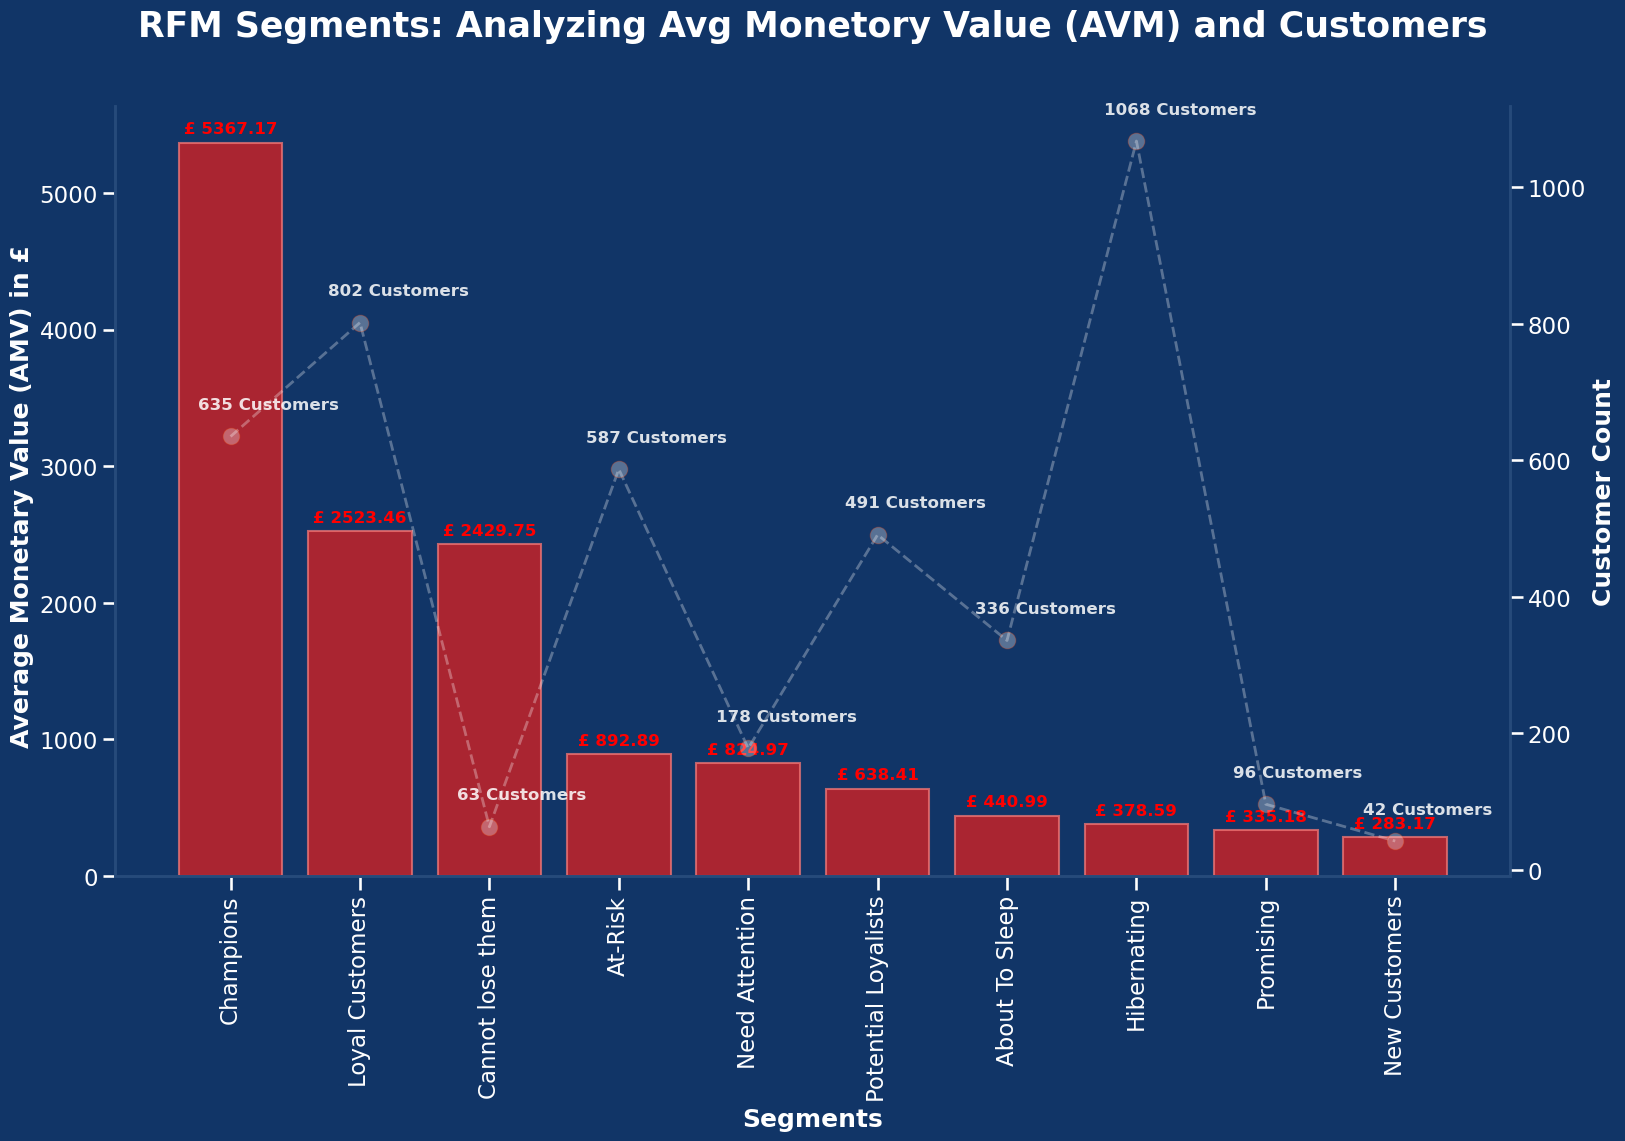

In [316]:
sns.set_context("talk")
plt.rcParams["axes.facecolor"] = "#113567"
fig, ax = plt.subplots(figsize = (18,10),facecolor = "#113567")

sns.barplot(y = rfm_monetary_size.MeanMonetary, x = rfm_monetary_size.index, ax = ax, color = "red",edgecolor="#f17776",alpha=0.75)

# Set spine colors
ax.spines['top'].set_color('#264a7a')
ax.spines['bottom'].set_color('#264a7a')
ax.spines['left'].set_color('#264a7a')
ax.spines['right'].set_color('#264a7a')
ax.tick_params(axis='x', colors='white',size=10,rotation=90)
ax.tick_params(axis='y', colors='white')
ax.set_xlabel("Segments",color="white", fontweight= "bold")
ax.set_ylabel("Average Monetary Value (AMV) in £ ",color="white", fontweight = "bold")

for p in ax.patches:
    ax.annotate("£ " + str(round(p.get_height(),2)),  
                (p.get_x() + p.get_width()/ 2., p.get_height() ),  
                xytext=(0, 10),  # Adjust the position of the text
                textcoords='offset points',
                ha='center', va='center',color = "red", fontweight = "bold",fontsize=12)

ax2=ax.twinx()
sns.lineplot(y = rfm_monetary_size.CustomerCount, x = rfm_monetary_size.index, ax = ax2, marker = "o",markersize=12, linewidth = 2,
             color = "white", markeredgecolor = "#F1480F",linestyle="--",alpha=0.3)

#ax2.axis("off")
ax2.spines['top'].set_color('#264a7a')
ax2.spines['bottom'].set_color('#264a7a')
ax2.spines['left'].set_color('#264a7a')
ax2.spines['right'].set_color('#264a7a')
ax2.set_xlabel(" ")
ax2.set_ylabel("Customer Count",color="white", fontweight = "bold")
ax2.tick_params(axis='y', colors='white')
for x, y in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x-0.25, y+40, str(y) + " Customers", color = "white", fontweight = "bold",fontsize=12,alpha=0.85)

plt.title("RFM Segments: Analyzing Avg Monetory Value (AVM) and Customers",fontsize=25,color="white", fontweight = "bold",y=1.08)

sns.despine(left = False, right = False, bottom = False,top = True)
plt.show()

## Segment wise Analysis

In [20]:
rfm = rfm_table2.groupby("Segment").agg({"CustomerID": "nunique",
                                        "Recency": "mean",
                                        "Frequency": "mean",
                                        "Monetary": "mean"})
rfm.rename(columns = {"CustomerID": "Segment Size"}, inplace = True)

cm = sns.light_palette("#A2A2A2", as_cmap = True)

rfm.T.style.background_gradient(cmap = cm, axis = 1)\
.format(precision=2)\
.highlight_min(axis = 1, color = "#195190")\
.highlight_max(axis = 1, color = "#D60000")

Segment,About To Sleep,At-Risk,Cannot lose them,Champions,Hibernating,Loyal Customers,Need Attention,New Customers,Potential Loyalists,Promising
Segment Size,336.00,587.00,63.00,635.00,1068.00,802.00,178.00,42.00,491.00,96.00
Recency,53.06,152.81,134.65,6.01,216.59,33.30,52.03,7.17,17.18,23.55
Frequency,1.14,2.85,8.30,12.04,1.09,6.39,2.30,1.00,1.99,1.00
Monetary,440.99,892.89,2429.75,5367.17,378.59,2523.46,824.97,283.17,638.41,335.18


## Distribution of Recency and Frequency in Segments

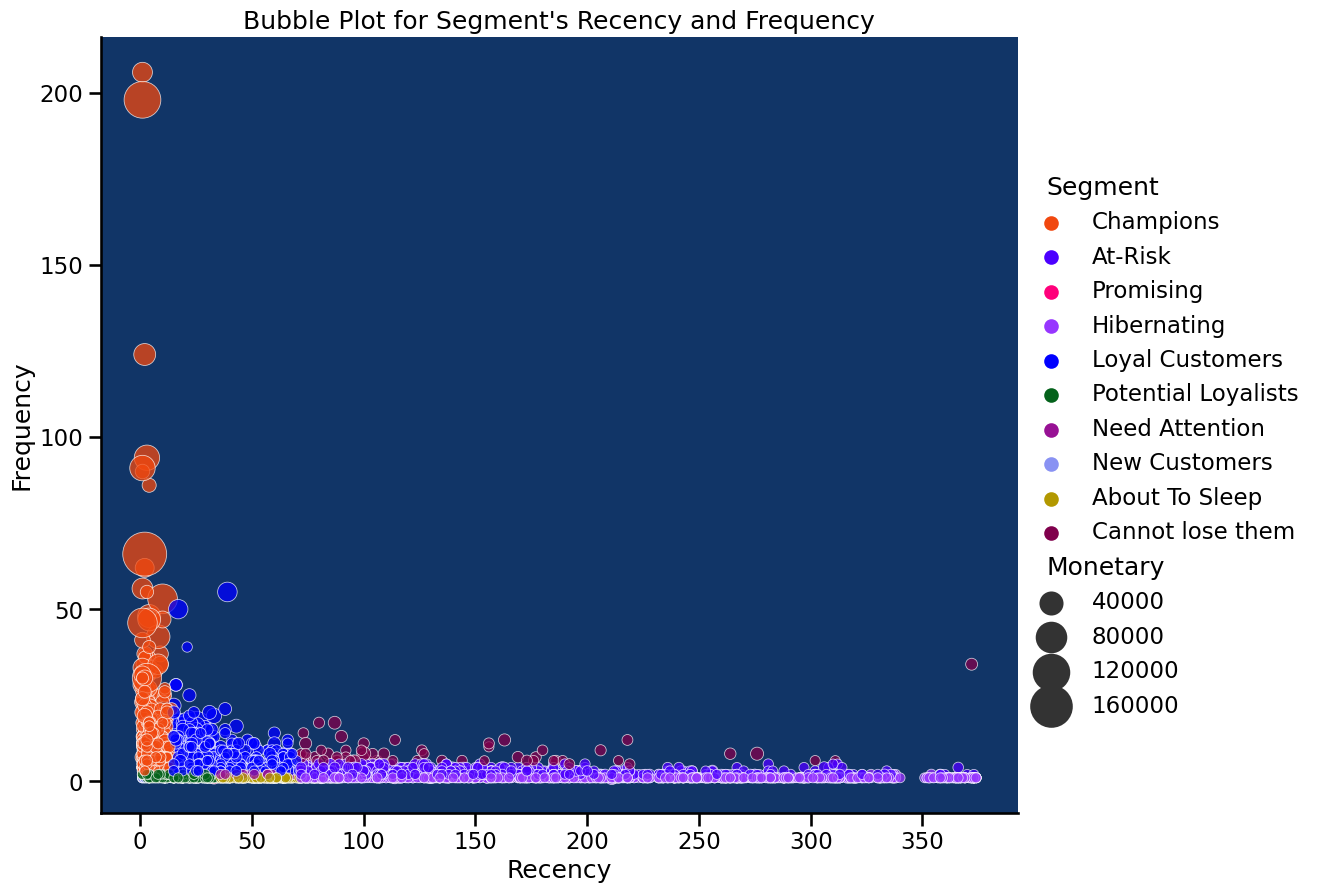

In [198]:
plt.rcParams["axes.facecolor"] = "#113567"
plt.rcParams["axes.grid"] = False

sns.relplot(x = "Recency", y = "Frequency", hue = "Segment", size = "Monetary", data = rfm_table2, palette = palette,
            height = 9, aspect = 1.2, sizes = (50, 1000),alpha=0.75)
plt.title("Bubble Plot for Segment's Recency and Frequency")
plt.show()

## Distribution of Monetory in Segments

In [22]:
monetary_per_segment = (rfm_table2.groupby("Segment")["Monetary"].sum() /\
                        rfm_table2.groupby("Segment")["Monetary"].sum().sum()).sort_values(ascending = False)

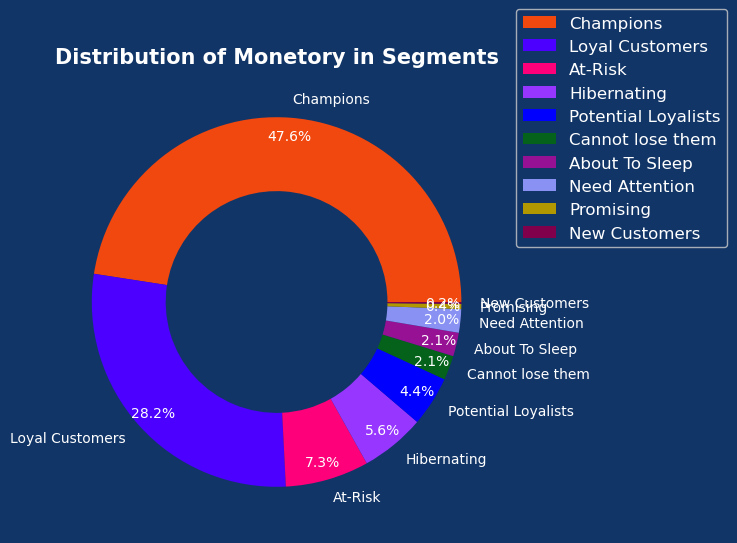

In [153]:


fig, ax = plt.subplots(figsize = (6,6), facecolor = "#113567")

wedges, texts, autotexts = ax.pie(
    monetary_per_segment.values, 
    labels=monetary_per_segment.index, 
    colors=palette, 
    wedgeprops=dict(width=0.4),
    autopct='%.1f%%', 
    textprops={'color': "white",'fontsize':10}
)

# Add a legend 
ax.legend(
    wedges, 
    monetary_per_segment.index, 
    loc="lower left", 
    bbox_to_anchor=(1, 0.6), 
    fontsize=12, 
    labelcolor='white'
)

for i, text in enumerate(texts):
    text.set_position((text.get_position()[0] * 1, text.get_position()[1] * 1))


for i, autotext in enumerate(autotexts):
    autotext.set_position((autotext.get_position()[0] * 1.5, autotext.get_position()[1] * 1.5))

plt.title("Distribution of Monetory in Segments",color="white",fontsize=15,fontweight="bold")


plt.show()

47.5% of total revenue comes from "Champions" segment, and 28% of total revenue comes from "Loyal Customers" segment. These two segments have 75% of company's total revenue.

<a id="section-four-five"></a>

# 5) Customer Segmentation with using RFM Metrics

In [156]:
rfm_table2.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
0,12347.0,2,7,4060.40,5,5,5,555,15,Champions
1,12348.0,75,4,1437.24,2,4,4,244,10,At-Risk
2,12349.0,19,1,1417.60,4,1,4,414,9,Promising
3,12350.0,310,1,294.40,1,1,2,112,4,Hibernating
4,12352.0,36,7,1385.74,3,5,4,354,12,Loyal Customers


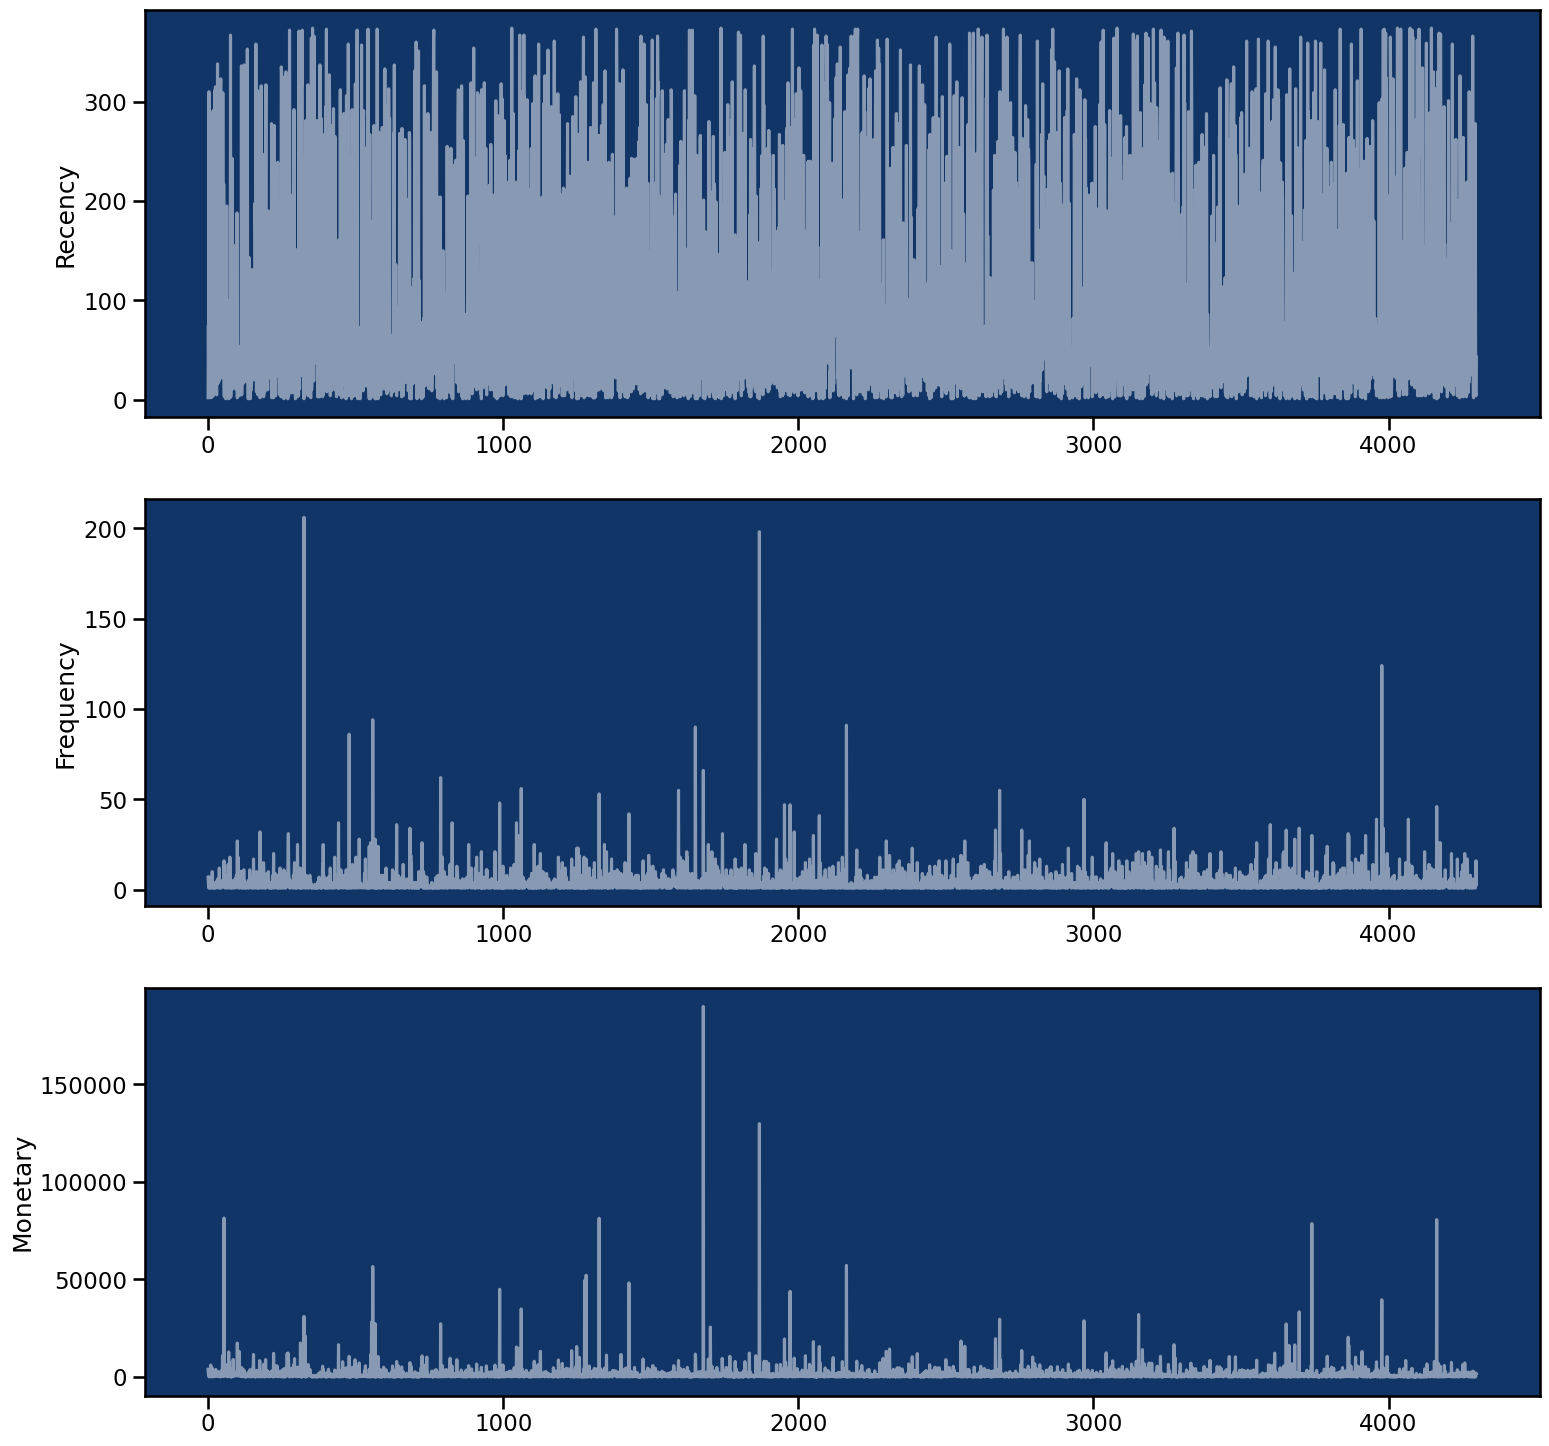

In [213]:
fig, axes = plt.subplots(3, 1, figsize=(18, 18))

for i,col in enumerate(["Recency", "Frequency", "Monetary"]):
     sns.lineplot(rfm_table2[col],ax=axes[i],color="white",alpha=0.5)

Preparing the data for clustering, performing data transformations as the data is skewed and have wide ranges.

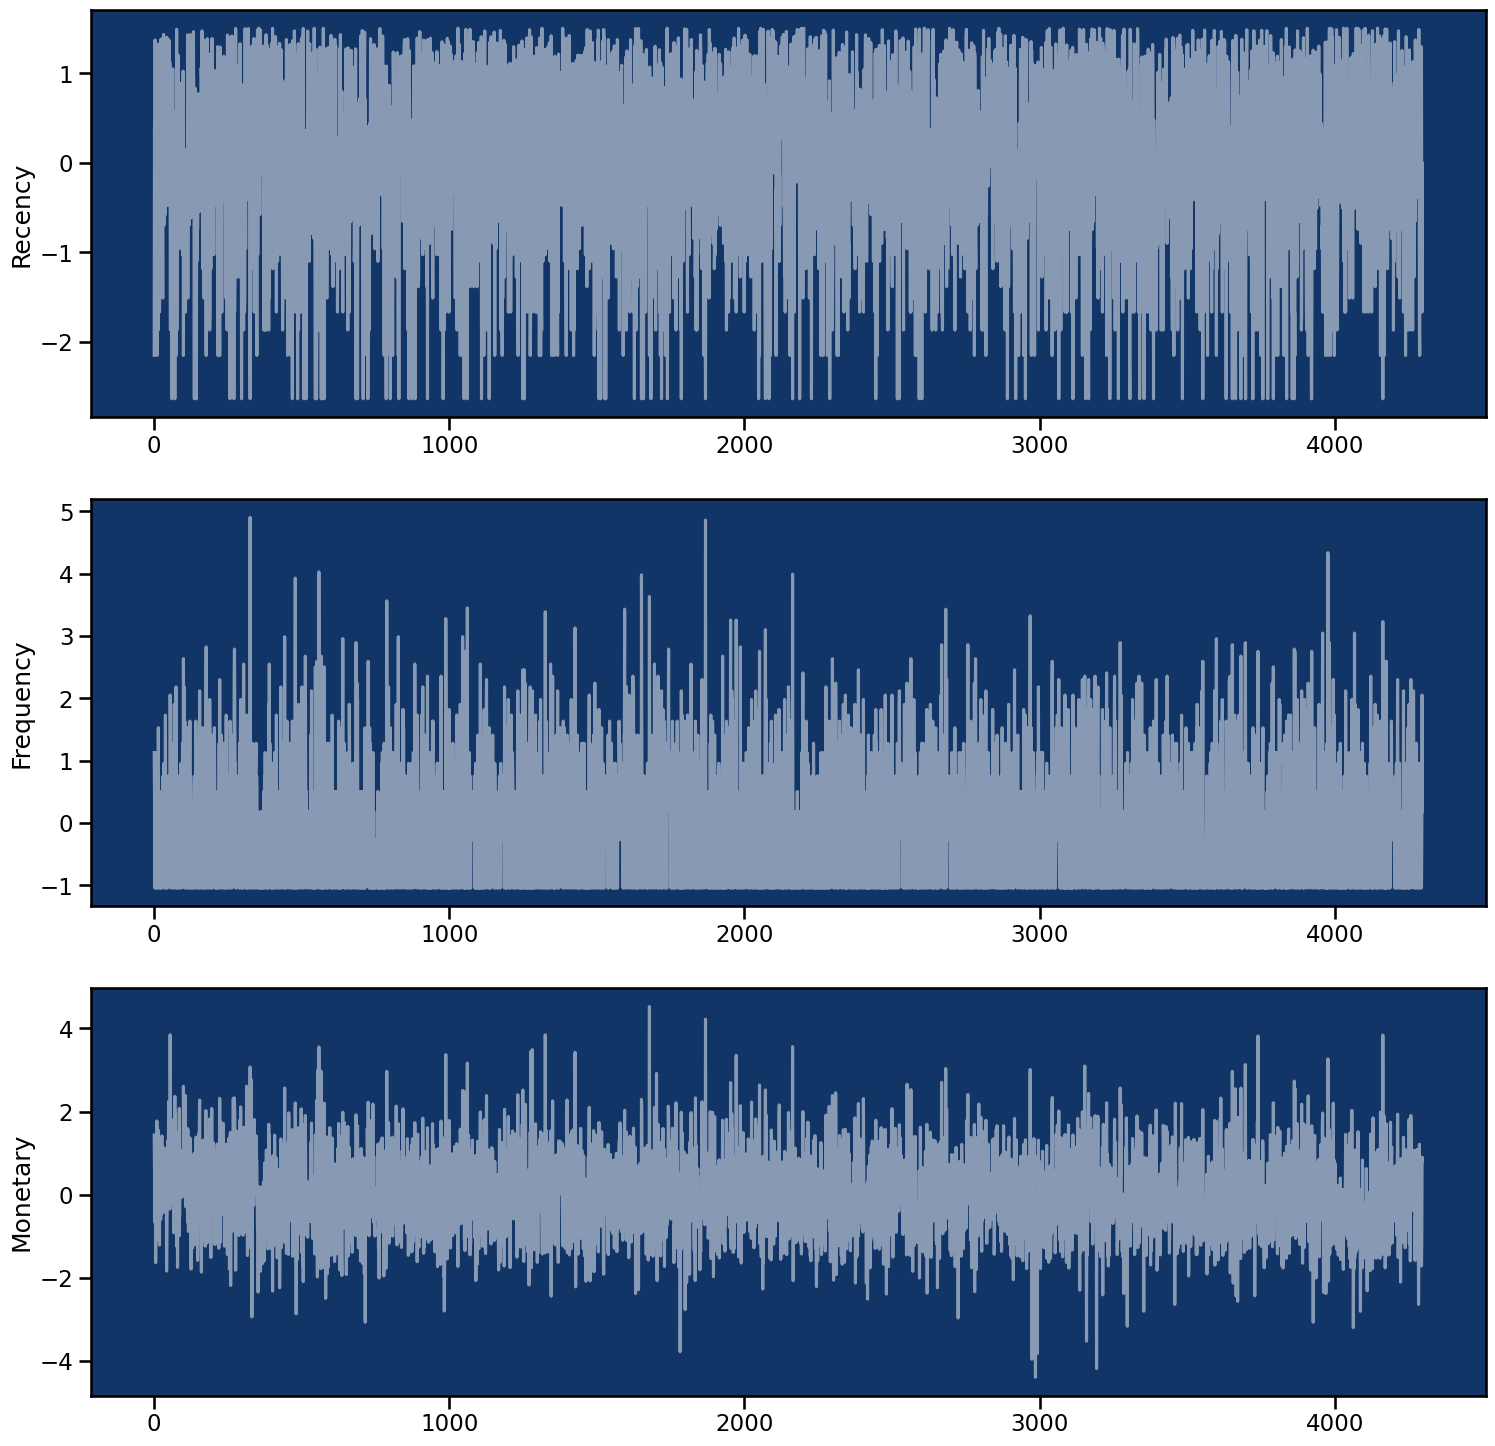

In [298]:
fig, axes = plt.subplots(3, 1, figsize=(18, 18))
rfm_clustering = rfm_table2[["Recency", "Frequency", "Monetary", "Segment"]]

for  i,col in enumerate(["Recency", "Frequency", "Monetary"]):

    scaler = StandardScaler()
    rfm_clustering[col] = np.log(rfm_clustering[col])
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[col].values.reshape(-1, 1))
    sns.lineplot(rfm_clustering[col],color="white",alpha=0.5,ax=axes[i])
    
rfm_melted = pd.melt(rfm_clustering, id_vars = "Segment", value_vars = ["Recency", "Frequency", "Monetary"],
                     var_name = "RFM", value_name = "Value")


K-Means clustering model:

K-means is an unsupervised machine learning algorithm, which is used for data clustering. In k-means algorithm number of clusters K is predetermined and the algorithm iteratively assigns each data point to one of the K clusters based on the feature similarity.

The optimal number of clusters I will found using the elbow method:


Using the Elbow Plot Visualizer, to get the optimum K value to perform clustering

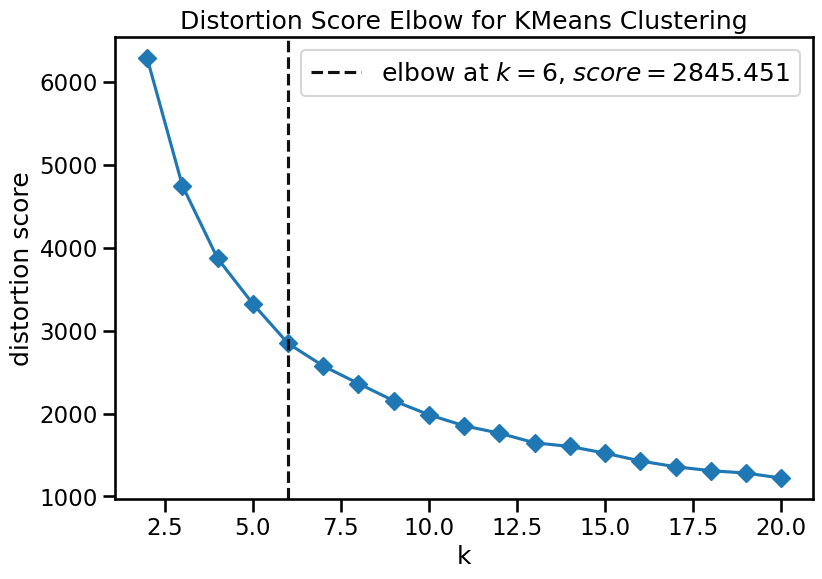

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [215]:
features = ["Recency", "Frequency", "Monetary"]

kmeans_ = KMeans(init = "k-means++", random_state = 42)

plt.rcParams["axes.facecolor"] = "white"
fig, ax = plt.subplots(figsize = (9, 6))

ax.grid(False)

visualizer = KElbowVisualizer(kmeans_, k = (2, 21), timings = False)

visualizer.fit(rfm_clustering[features])
visualizer.show()

As the optimum k value from elbow plot is 6, we perform kmeans clustering with k=6

In [302]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
kmeans.fit(rfm_clustering[features])
rfm_clustering['cluster'] = kmeans.labels_

rfm_clustering

,Recency,Frequency,Monetary,Segment,cluster
0,-2.149991,1.129100,1.436567,Champions,5
1,0.383006,0.504604,0.601759,At-Risk,2
2,-0.576597,-1.042412,0.590699,Promising,3
3,1.374783,-1.042412,-0.672723,Hibernating,1
4,-0.129954,1.129100,0.572428,Loyal Customers,0
...,...,...,...,...,...
4293,1.298638,-1.042412,-1.065512,Hibernating,1
4294,0.998730,-1.042412,-1.711828,Hibernating,1
4295,-1.181131,-0.268904,-1.076942,Potential Loyalists,3
4296,-1.665561,2.051620,0.902328,Champions,5


In [303]:
rfm_clustering

,Recency,Frequency,Monetary,Segment,cluster
0,-2.149991,1.129100,1.436567,Champions,5
1,0.383006,0.504604,0.601759,At-Risk,2
2,-0.576597,-1.042412,0.590699,Promising,3
3,1.374783,-1.042412,-0.672723,Hibernating,1
4,-0.129954,1.129100,0.572428,Loyal Customers,0
...,...,...,...,...,...
4293,1.298638,-1.042412,-1.065512,Hibernating,1
4294,0.998730,-1.042412,-1.711828,Hibernating,1
4295,-1.181131,-0.268904,-1.076942,Potential Loyalists,3
4296,-1.665561,2.051620,0.902328,Champions,5


In [307]:
test=rfm_clustering.drop('Segment',axis=1)

In [308]:
test.to_csv("kmeans_rfm_cluster_result.csv")

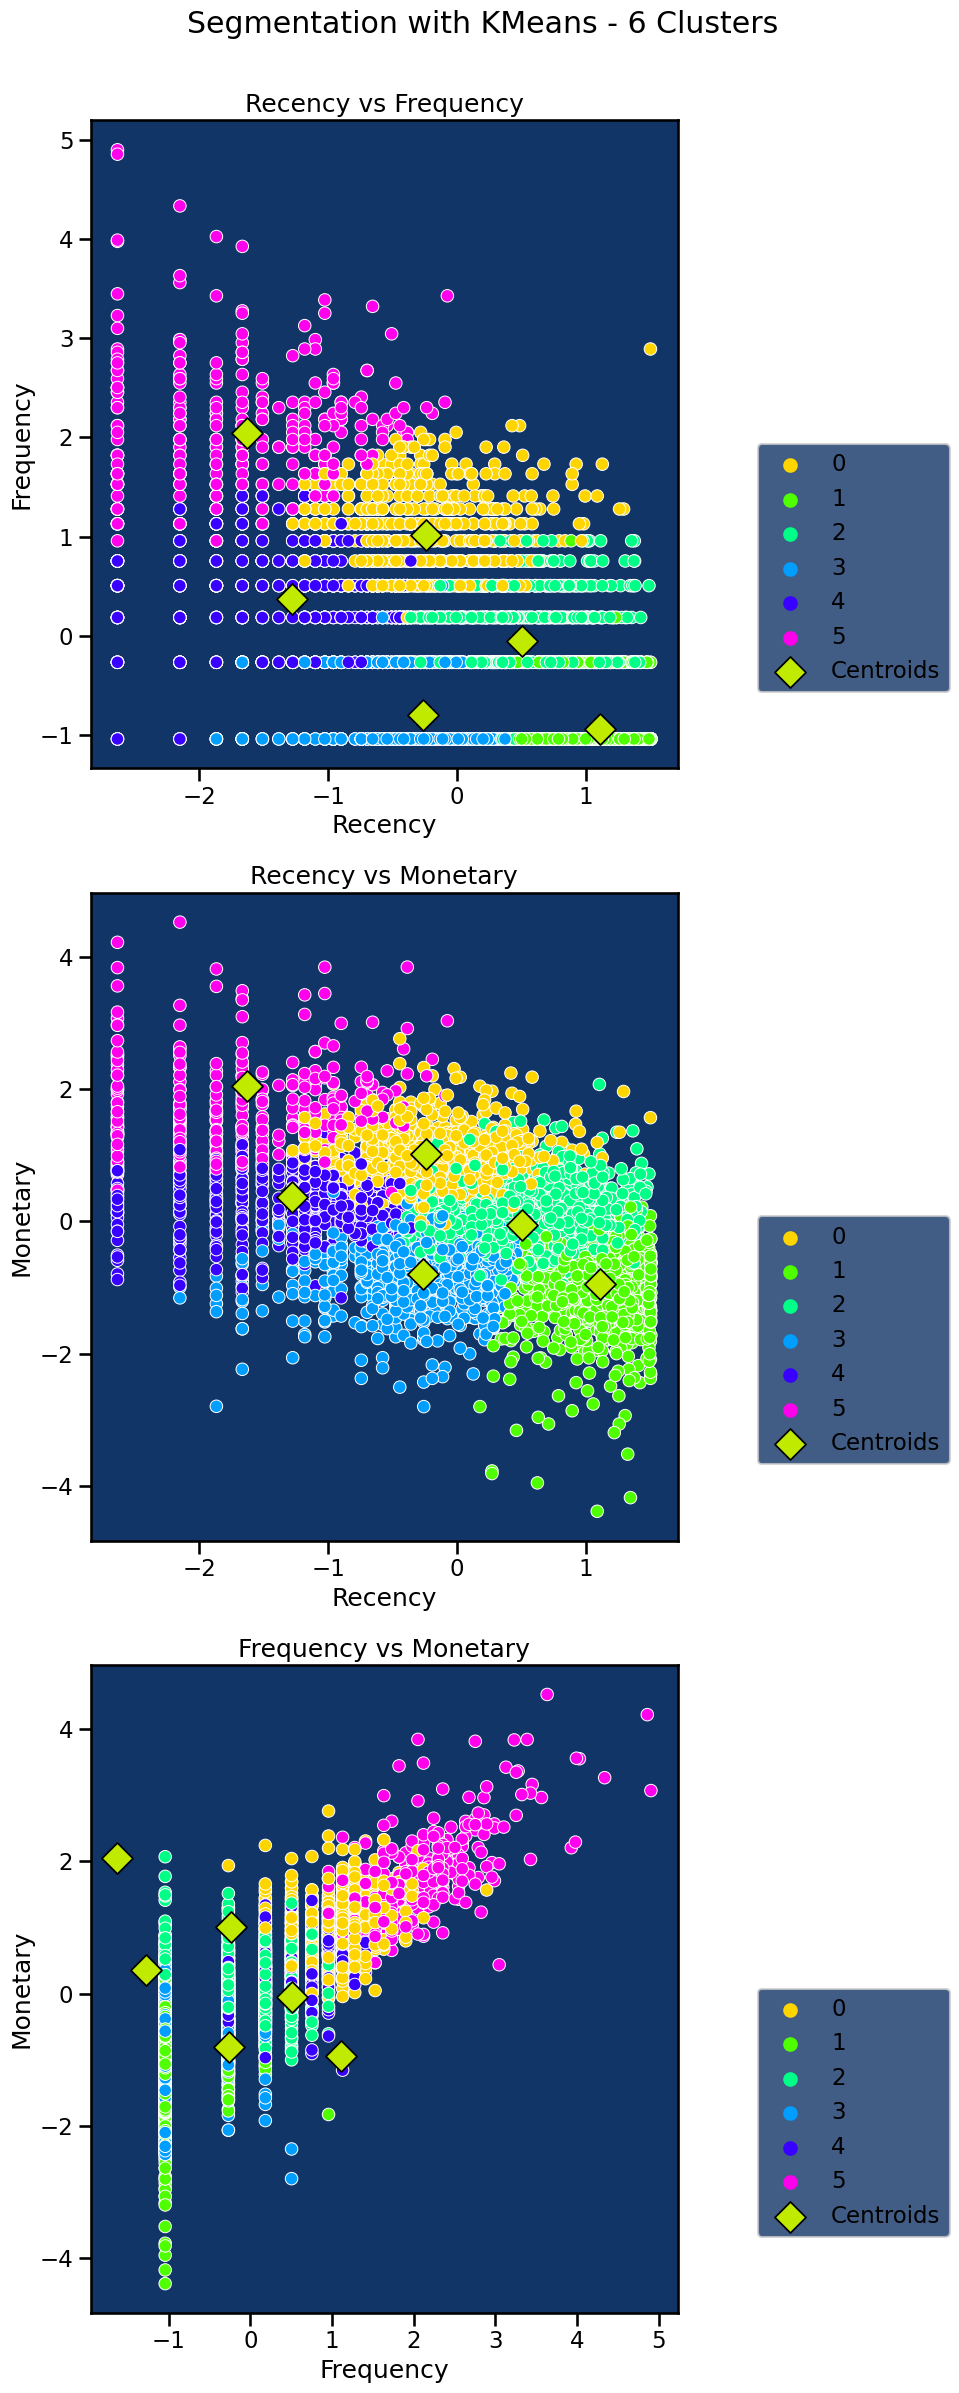

In [304]:
plt.rcParams["axes.facecolor"] = "#113567"

fig, axes = plt.subplots(3, 1, figsize = (10,24))

for i, feature in list(enumerate(combinations(["Recency", "Frequency", "Monetary"], 2))):

    sns.scatterplot(x = rfm_clustering[feature[0]], y = rfm_clustering[feature[1]], hue = rfm_clustering['cluster'],
                    palette = palette[: len(set(rfm_clustering['cluster']))], ax = axes[i]).set_title(feature[0] + " vs " + feature[1])
    
    sns.scatterplot(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1],
                    s = 250, color = '#C0EB00', label = 'Centroids', marker = "D", ax = axes[i], edgecolor = "black")
       # legend
    axes[i].legend( bbox_to_anchor=(1.3, 0.1), loc="lower center")    

    plt.suptitle("Segmentation with KMeans - 6 Clusters",y=1)
    
    plt.subplots_adjust(hspace=0.25,wspace=2)
    plt.tight_layout()
plt.show()
    
    

Plotting 3D visualization for the clusters, we get the following 

Text(0.5, 0.92, 'Segmentation with KMeans - 6 Clusters')

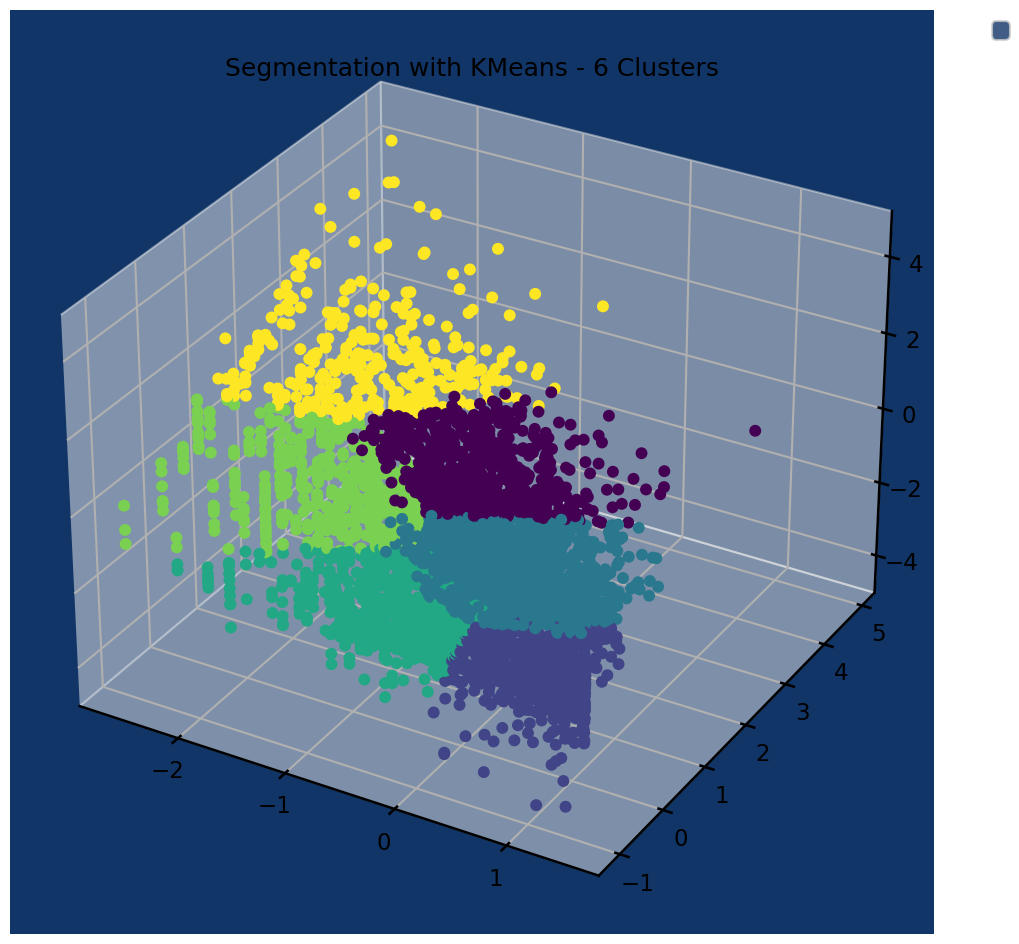

In [305]:
from mpl_toolkits import mplot3d

sns.set_palette("hsv", 8)
fig=plt.figure(figsize=(12,12))
ax=plt.axes(projection='3d')
ax.scatter(rfm_clustering["Recency"], rfm_clustering["Frequency"], rfm_clustering["Monetary"],c=rfm_clustering["cluster"],s=50,alpha=1)
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Segmentation with KMeans - 6 Clusters",y=1)

Plotting the distributions for the clusters

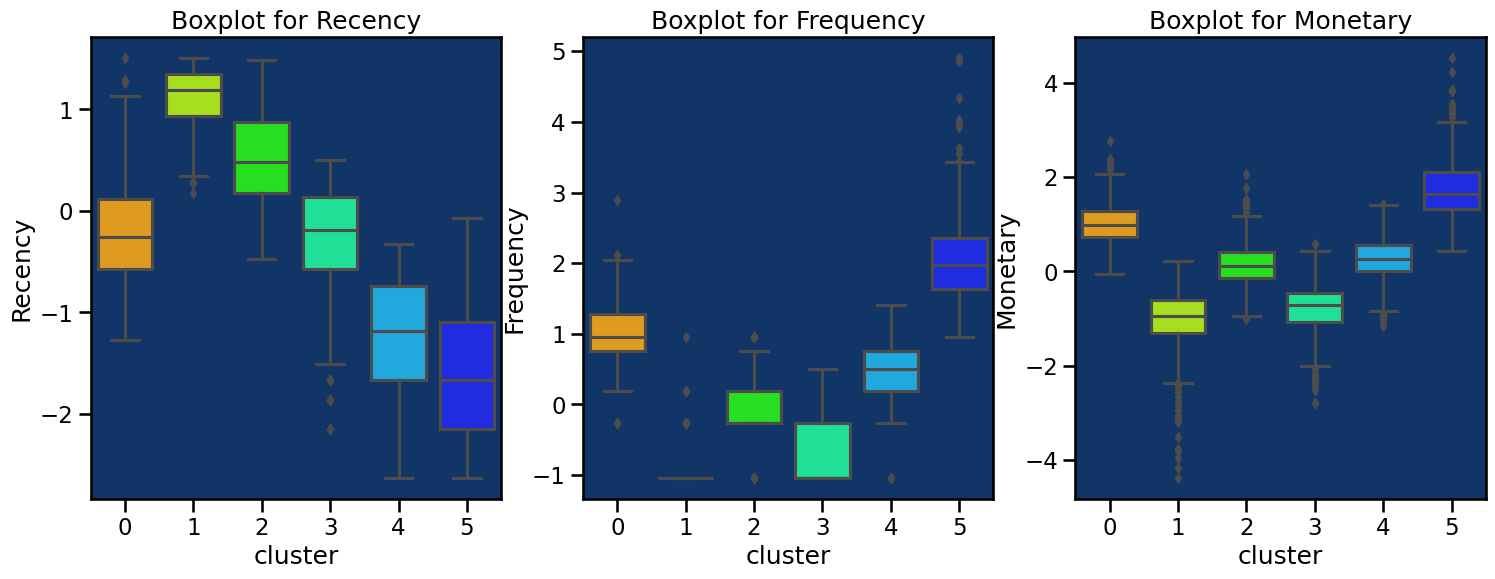

In [306]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))


for i, feature in enumerate(["Recency", "Frequency", "Monetary"]):  

    sns.boxplot(x = 'cluster', y = feature, data = rfm_clustering, ax = axes[i]).set_title("Boxplot for "+feature)


plt.show()

Analysis of RFM Clusters

Based on the K-means clustering algorithm applied to the RFM (Recency, Frequency, Monetary) data, here is a detailed description and characteristics of each cluster, along with category recommendations:
Cluster 0

    Recency: Moderate
    Frequency: High
    Monetary: Moderate
    Characteristics: This cluster includes customers who purchase relatively frequently and have moderate spending. They are moderately recent in their purchase behavior.
    Category: Loyal Customers – These customers are valuable due to their frequent purchases. They should be nurtured with loyalty programs and personalized offers.

Cluster 1

    Recency: High
    Frequency: Low
    Monetary: Low
    Characteristics: Customers in this cluster haven't made recent purchases and show low purchase frequency and spending.
    Category: At-Risk Customers – These customers are at risk of churning. Efforts should be made to re-engage them through targeted marketing campaigns and special discounts.

Cluster 2

    Recency: Moderate
    Frequency: Moderate
    Monetary: Moderate
    Characteristics: Customers in this cluster have average values across recency, frequency, and monetary metrics.
    Category: Average Customers – These customers are neither exceptionally loyal nor at risk. Regular engagement and good customer service will help maintain their current purchasing behavior.

Cluster 3

    Recency: Moderate
    Frequency: Low
    Monetary: Moderate
    Characteristics: This cluster includes customers with moderate spending but lower purchase frequency. Their recency is also moderate.
    Category: Potential Loyalists – With the right incentives, these customers could increase their purchase frequency and become more loyal. Focus on personalized marketing to increase engagement.

Cluster 4

    Recency: Low
    Frequency: Moderate
    Monetary: Low
    Characteristics: Customers in this cluster are fairly recent in their purchase behavior but have low monetary value and moderate frequency.
    Category: New Customers – These customers have recently started engaging but have not spent much yet. Encouraging repeat purchases through welcome offers and onboarding can help increase their lifetime value.

Cluster 5

    Recency: Low
    Frequency: High
    Monetary: High
    Characteristics: This cluster consists of customers who have made recent, frequent purchases and have high spending.
    Category: Best Customers – These are the most valuable customers. They should be given VIP treatment, exclusive offers, and top-notch customer service to maintain their loyalty.

Summary

    Cluster 0: Loyal Customers
    Cluster 1: At-Risk Customers
    Cluster 2: Average Customers
    Cluster 3: Potential Loyalists
    Cluster 4: New Customers
    Cluster 5: Best Customers

Understanding these clusters helps in creating targeted strategies for different customer segments, enhancing overall customer satisfaction and business performance. ​
​

In [310]:
predicted_segment = {
    0: 'Loyal Customers',
    1: 'At-Risk Customers',
    2: 'Average Customers',
    3: 'Potential Loyalists',
    4: 'New Customers',
    5: 'Best Customers'
}

# Add a new column 'segment' to the DataFrame based on the 'cluster' column
rfm_clustering['predicted_segment'] = rfm_clustering['cluster'].map(predicted_segment)

rfm_clustering.head()

,Recency,Frequency,Monetary,Segment,cluster,predicted_segment
0,-2.149991,1.129100,1.436567,Champions,5,Best Customers
1,0.383006,0.504604,0.601759,At-Risk,2,Average Customers
2,-0.576597,-1.042412,0.590699,Promising,3,Potential Loyalists
3,1.374783,-1.042412,-0.672723,Hibernating,1,At-Risk Customers
4,-0.129954,1.129100,0.572428,Loyal Customers,0,Loyal Customers


Conclusion:

Targeted Marketing Strategies for Each Customer Segment
1. Best Customers (Cluster 5)

Characteristics: Recent, frequent purchases with high spending.

Strategies:

    VIP Programs: Offer exclusive benefits such as early access to new products, special discounts, and personalized services.
    Personalized Communication: Send personalized emails or messages highlighting products that match their purchase history.
    Loyalty Rewards: Implement a robust loyalty program where they can earn points for every purchase and redeem them for rewards.
    Exclusive Events: Invite them to special events, webinars, or product launches to make them feel valued.

2. Loyal Customers (Cluster 0)

Characteristics: Frequent purchases, moderate spending, moderate recency.

Strategies:

    Surprise and Delight: Occasionally send them surprise discounts or free samples to show appreciation.
    Referral Programs: Encourage them to refer friends and family with rewards for successful referrals.
    Feedback Requests: Engage them by asking for feedback and suggestions, making them feel involved in the brand’s growth.
    Regular Updates: Keep them informed about upcoming sales, new arrivals, and exclusive offers through newsletters.

3. At-Risk Customers (Cluster 1)

Characteristics: Low frequency, low monetary, high recency.

Strategies:

    Re-engagement Campaigns: Send targeted campaigns with special discounts or incentives to encourage them to return.
    Win-back Offers: Offer significant discounts or promotions that are time-sensitive to prompt immediate action.
    Survey and Feedback: Send surveys to understand why they stopped purchasing and address any issues they mention.
    Personalized Recommendations: Highlight new or relevant products that match their past purchases to rekindle their interest.

4. Average Customers (Cluster 2)

Characteristics: Average values across recency, frequency, and monetary.

Strategies:

    Consistent Engagement: Keep them engaged with regular updates, promotions, and newsletters.
    Cross-Selling and Up-Selling: Recommend products that complement their previous purchases to increase average order value.
    Seasonal Promotions: Target them with special offers during key shopping seasons (e.g., Black Friday, Christmas).
    Customer Service: Ensure excellent customer service to maintain satisfaction and encourage repeat purchases.

5. Potential Loyalists (Cluster 3)

Characteristics: Moderate spending, low frequency, moderate recency.

Strategies:

    Incentivize Frequency: Offer discounts or rewards for more frequent purchases, like “buy more, save more” deals.
    Personalized Offers: Provide personalized offers based on their browsing history and past purchases.
    Content Marketing: Send them valuable content, such as tips, guides, or blog posts related to their interests.
    Follow-Up: After each purchase, follow up with product recommendations and a thank you note to build a stronger relationship.

6. New Customers (Cluster 4)

Characteristics: Recent purchases, moderate frequency, low spending.

Strategies:

    Welcome Campaigns: Send a welcome email series with a special offer for their next purchase.
    Onboarding: Provide information on how to make the most of their purchases and introduce them to your brand’s values and offerings.
    First-Time Buyer Discounts: Offer a discount on their next purchase to encourage repeat business.
    Engagement: Engage them with personalized recommendations and highlight popular products to drive additional purchases.

Implementation Tips

    Segmented Email Marketing: Use email marketing platforms that allow segmentation to tailor messages for each customer group.
    Customer Relationship Management (CRM): Utilize a CRM system to track customer interactions and tailor your approach based on their behavior.
    Data Analysis: Continuously analyze customer data to refine your strategies and ensure they remain effective.
    Feedback Loop: Regularly collect feedback to understand customer needs and adjust your marketing strategies accordingly.

By implementing these targeted strategies, you can enhance customer engagement, increase loyalty, and drive higher revenue from each customer segment.